# Exploratory Data Analysis
---
Goal of the notebook: Do EDA to determine which black box model to select.

Inputs of the notebook:

Output of the notebook:


Takeaways:

Questions, thoughts and remarks:

## Dependencies and path
Adjust the argument in `sys.path.append` to align with your specific requirements.

In [2]:
import pandas as pd 
import numpy as np
import os
import sys

%load_ext autoreload
%autoreload 2

os.chdir('C:/Users/dorab/OneDrive - Ecole Polytechnique/Documents/Data Science for Business HEC x Polytechnique/Year 2/Algorithmic Fairness and Interpretability/final_project/afi_final_project')

## 1. Load the data

In [3]:
df = pd.read_excel("data/dataproject2024.xlsx")

## 2. Overview

In [4]:
# Overview of the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7430 entries, 0 to 7429
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    7430 non-null   int64  
 1   Job tenure            7430 non-null   int64  
 2   Age                   7430 non-null   int64  
 3   Car price             7430 non-null   int64  
 4   Funding amount        7430 non-null   int64  
 5   Down payment          7430 non-null   int64  
 6   Loan duration         7430 non-null   int64  
 7   Monthly payment       7430 non-null   float64
 8   Credit event          7430 non-null   int64  
 9   Married               7430 non-null   int64  
 10  Homeowner             7430 non-null   int64  
 11  Default (y)           7430 non-null   int64  
 12  Pred_default (y_hat)  7430 non-null   int64  
 13  PD                    7430 non-null   float64
 14  Group                 7430 non-null   int64  
dtypes: float64(2), int64(

In [5]:
num_features = [
    "Job tenure",
    "Age",
    "Car price",
    "Funding amount",
    "Loan duration",
    "Monthly payment",
]

cat_features = ["Down payment", "Credit event", "Married", "Homeowner"]

In [6]:
# Summary statistics of numerical columns
print(df.describe())

                ID   Job tenure          Age     Car price  Funding amount  \
count  7430.000000  7430.000000  7430.000000   7430.000000     7430.000000   
mean   3715.500000     9.329475    45.169717  12931.183311    11457.803769   
std    2145.000583     9.978638    14.790760   6202.407112     6015.033981   
min       1.000000     0.000000    18.000000    546.000000      546.000000   
25%    1858.250000     2.000000    33.000000   8147.750000     6845.250000   
50%    3715.500000     5.000000    46.000000  11950.000000    10382.500000   
75%    5572.750000    15.000000    55.000000  16500.000000    15000.000000   
max    7430.000000    58.000000    89.000000  47051.000000    30000.000000   

       Down payment  Loan duration  Monthly payment  Credit event  \
count   7430.000000    7430.000000      7430.000000   7430.000000   
mean       0.089367      56.220054         0.105143      0.022073   
std        0.285293      19.385787         0.061121      0.146930   
min        0.000000  

## 3. Distribution

c:\Users\dorab\OneDrive - Ecole Polytechnique\Documents\Data Science for Business HEC x Polytechnique\Year 2\Algorithmic Fairness and Interpretability\final_project\afi_final_project\.venv\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


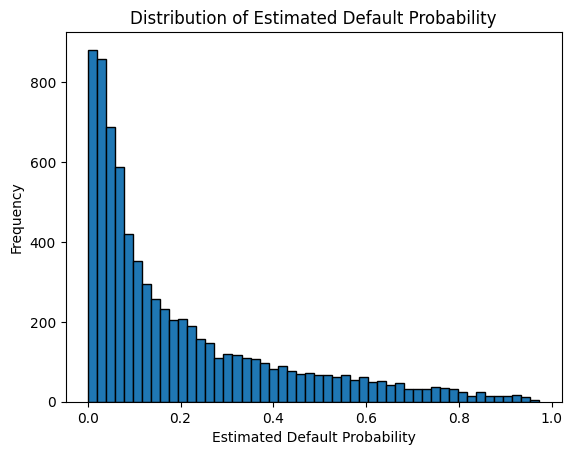

In [7]:
import matplotlib.pyplot as plt

# Histogram using matplotlib
plt.hist(df["PD"], bins=50, edgecolor="black")
plt.title("Distribution of Estimated Default Probability")
plt.xlabel("Estimated Default Probability")
plt.ylabel("Frequency")
plt.show()

Very skewed to the right.

## 4. Correlation

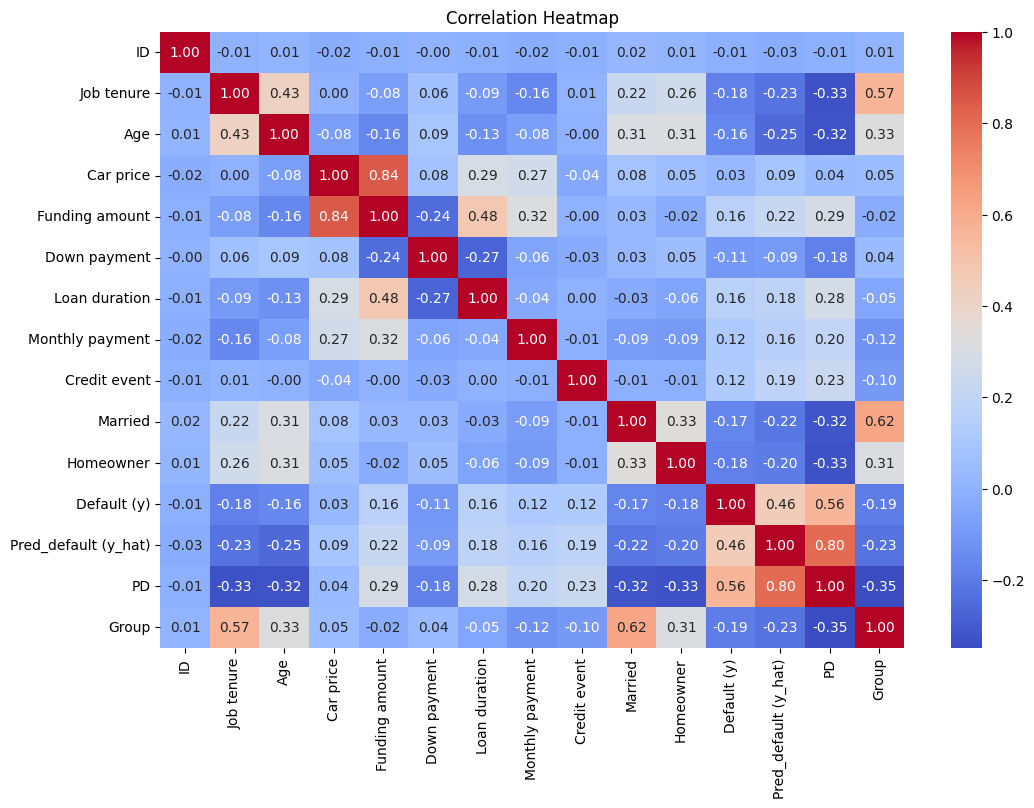

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Quite some correlated features:
- group + job tenure
- group + married
- homeowner + married
- loan duration + funding amount +  car price + monthly payment


We expect the features with the highest importance to be:
- job tenure
- age
- married
- homeowner
- group
- also loan duration and funding amount (but slightly less)

## 5. Multicollinearity

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
X = df.drop("PD", axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(len(X.columns))
]

print(vif_data)

                 feature        VIF
0                     ID   3.592593
1             Job tenure   3.406223
2                    Age  10.183947
3              Car price  27.902986
4         Funding amount  30.490185
5           Down payment   1.657359
6          Loan duration   9.725592
7        Monthly payment   4.299240
8           Credit event   1.095462
9                Married   4.080311
10             Homeowner   2.007662
11           Default (y)   1.645297
12  Pred_default (y_hat)   1.624522
13                 Group   3.546720


Quite a few features have very high VIF values (age, car price, funding amount, loan duration) indicating that there is multicollinearity between our features. This means that we should prefer tree-based algorithms to a linear regression or logistic regression. If we do linear regression we should consider applying a ridge regression or lasso to remove some correlated features.

## 6. Check for Non-Linearity

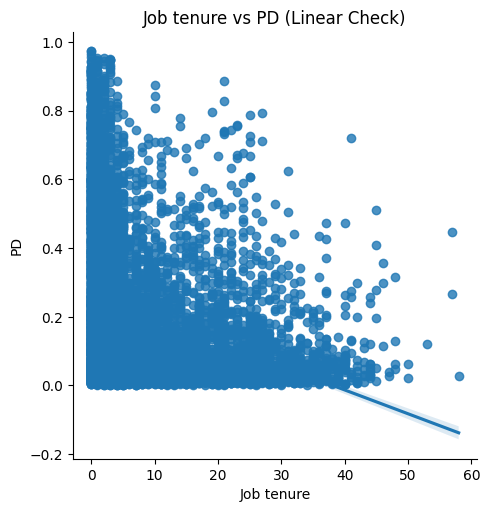

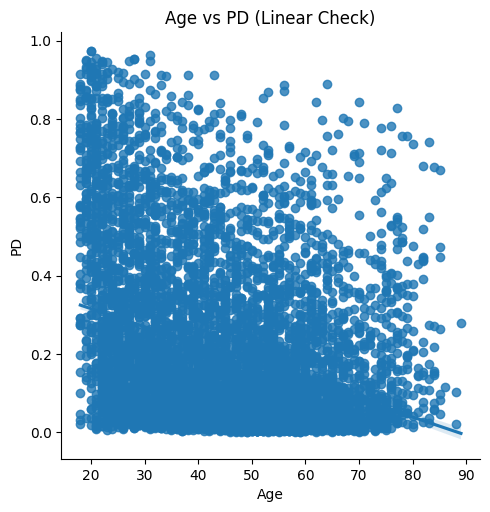

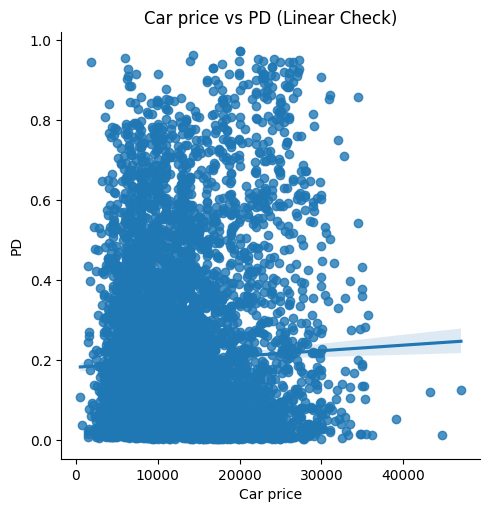

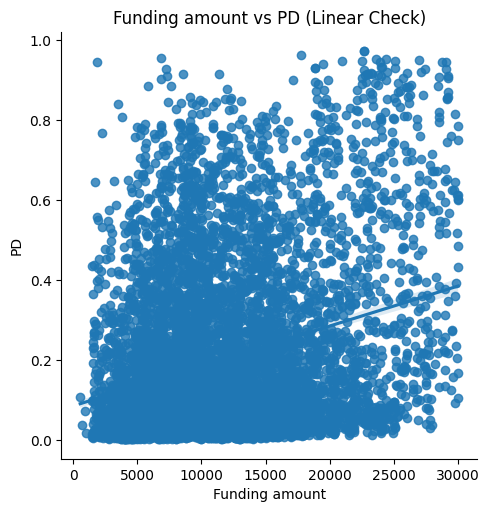

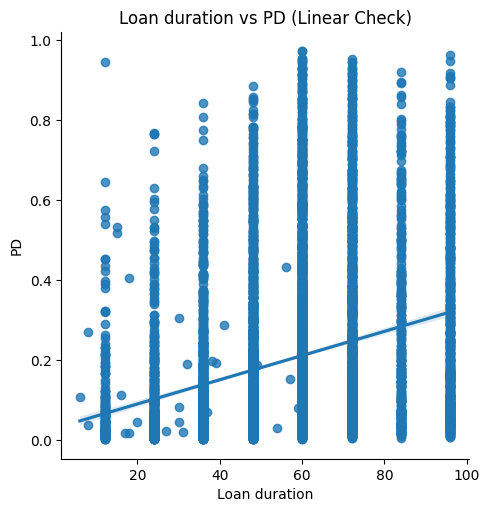

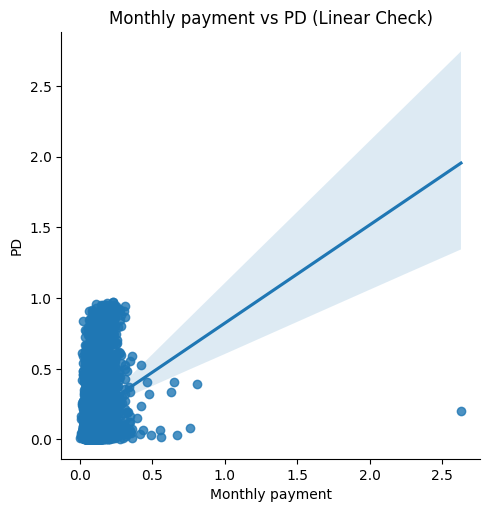

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for linear relationships with scatterplots for continuous variables
for col in num_features:
    if col != "target":  # Ensure you're not plotting the target against itself
        sns.lmplot(x=col, y="PD", data=df)
        plt.title(f"{col} vs PD (Linear Check)")
        plt.show()

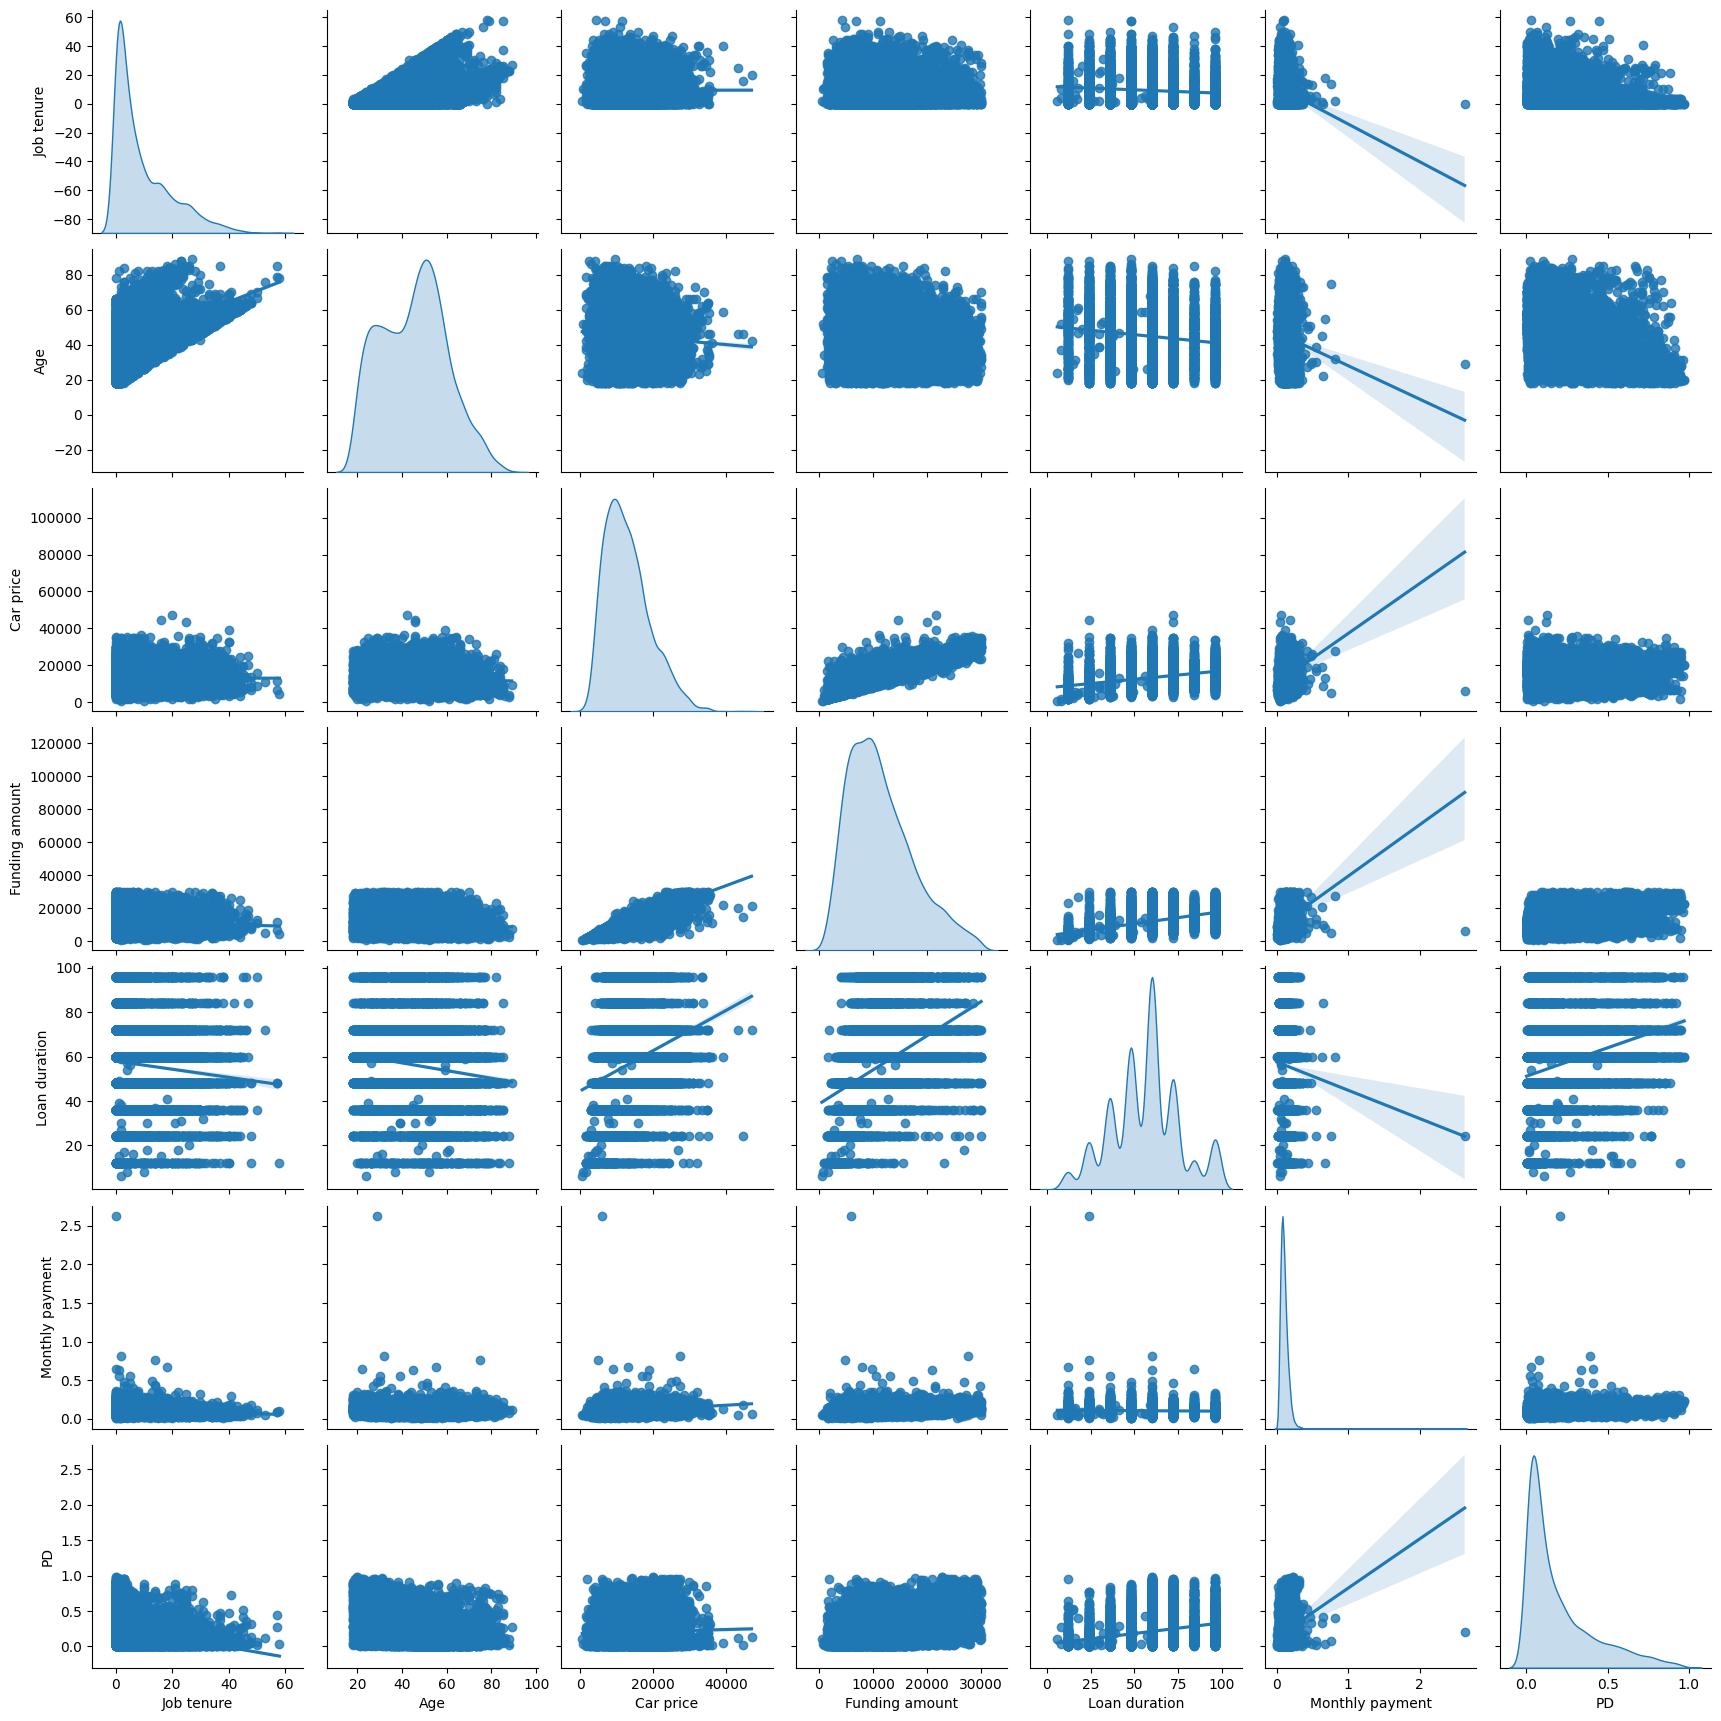

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 1. Filter the DataFrame to include only numerical features
df_num = df[num_features + ["PD"]]  # Add 'PD' to include the target for pairplot

# 2. Pairplot to detect non-linear relationships among numerical features
sns.pairplot(df_num, diag_kind="kde", kind="reg")  # kind="reg" adds regression line
plt.show()

Key Features in the Pairplot:
Diagonal Plots: These show the distribution (kernel density estimate or histogram) of individual variables.
Off-Diagonal Plots: These show the pairwise relationships between variables, with a regression line in some cases, allowing us to see the strength and type of the relationships.
1. PD (Target Variable) vs. Other Features:
PD vs Job Tenure:

There is a negative relationship between PD and Job Tenure. As job tenure increases, PD tends to decrease, although the relationship is not perfectly linear.
There are some outliers for very high job tenure values where PD remains high.
This suggests that job stability (higher job tenure) is associated with lower probabilities of default, but the effect might diminish for extreme values.
PD vs Age:

The relationship between PD and Age is slightly negative but appears to be non-linear. There is some clustering around younger ages with higher PD, but the relationship flattens for older ages.
The regression line shows a downward trend, but the scatter suggests some variability at all age levels.
PD vs Car Price:

The relationship between PD and Car Price is less clear. There are some clusters at specific car price levels, suggesting that there might not be a clear linear relationship between these two.
This is likely because car prices are not continuous (they have specific levels), and their effect on PD is likely mediated by other factors (like income or loan terms).
PD vs Funding Amount:

The relationship between PD and Funding Amount is non-linear. There seems to be a clustering of PD values at certain funding amounts (like $5,000 and $10,000), with a slight negative trend overall.
The regression line suggests a downward slope, but the variability at different funding amounts suggests that this feature alone might not explain PD well.
PD vs Loan Duration:

There appears to be some positive correlation between PD and loan duration. As loan duration increases, PD tends to increase as well, but this relationship is not perfectly linear, with clusters around certain durations.
This suggests that longer loans may be associated with higher probabilities of default, which is a common trend, but the effect may depend on other factors.
PD vs Monthly Payment:

This feature shows a non-linear relationship with PD. For lower monthly payments, PD seems to be high, but the relationship flattens as monthly payment increases.
This suggests that borrowers with lower monthly payments might have higher risks of default, possibly due to financial constraints. However, once monthly payments cross a certain threshold, the risk may not decrease further.
2. Relationships Between Features (Non-Target Variables):
Job Tenure vs Age:

There's a clear positive linear relationship between job tenure and age, which is expected since older individuals tend to have longer job tenures.
Funding Amount vs Loan Duration:

The relationship between funding amount and loan duration shows some clusters, suggesting that longer loans may be associated with higher funding amounts, though this relationship is not smooth or continuous.
Loan Duration vs Monthly Payment:

There's a non-linear relationship between loan duration and monthly payment. For short loan durations, monthly payments are spread over a wider range, but for longer durations, the payments appear more clustered.
Conclusion on Model Choice:
Linear Models:
Linear Regression or Logistic Regression might not capture the complexities in the data effectively because:
Many of the relationships between the independent variables and the target variable (PD) show non-linear patterns or clusters that a linear model may fail to handle well.
There are also some outliers and potential heteroscedasticity (the spread of PD values changes depending on the level of some features).
Non-Linear Models:
Since several features show non-linear relationships with PD (e.g., Age, Funding Amount, Loan Duration, Monthly Payment), non-linear models would likely perform better. These include:
Decision Trees: Can handle non-linearity and interactions between features without needing transformations.
Random Forests: Can capture non-linear relationships and are robust to outliers and overfitting.
Gradient Boosting Machines (GBM) or XGBoost: These are powerful models that work well for both classification and regression problems, handling non-linear relationships effectively.
Polynomial Regression:
Adding polynomial terms (as we did in the previous example) could help a linear regression model better capture the non-linearity in the data. However, this requires careful tuning to avoid overfitting and might not perform as well as tree-based models in capturing interactions between features.
Neural Networks:
Neural Networks could also be a good choice given the non-linearity in the relationships. However, they may require more data and careful tuning to avoid overfitting. They are particularly useful if you suspect interactions between the features are complex and not easily captured by simpler models.

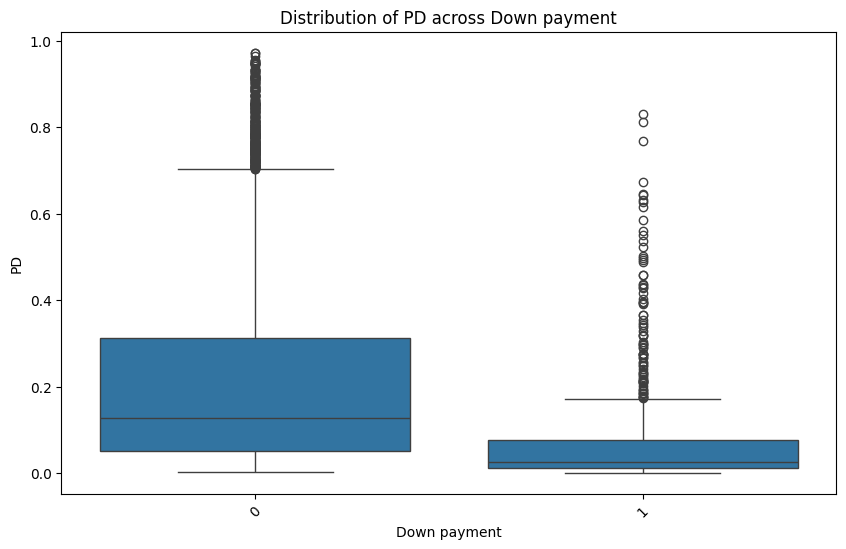

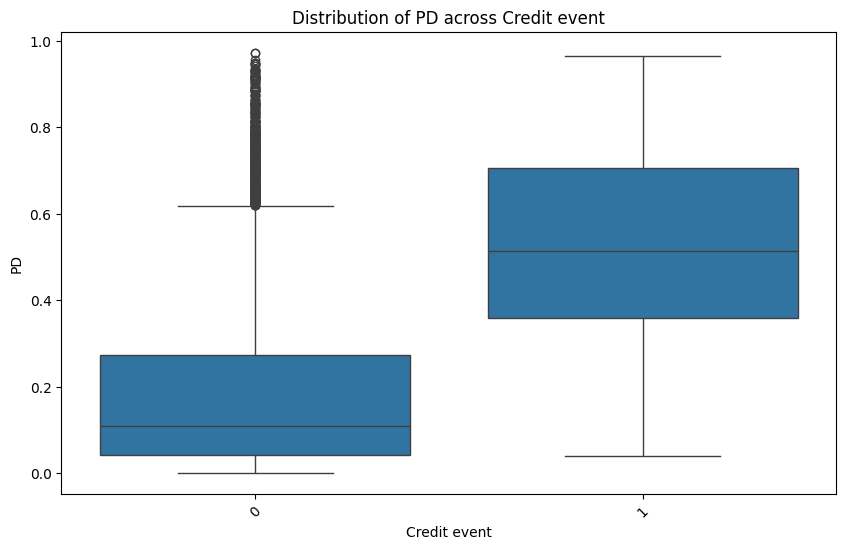

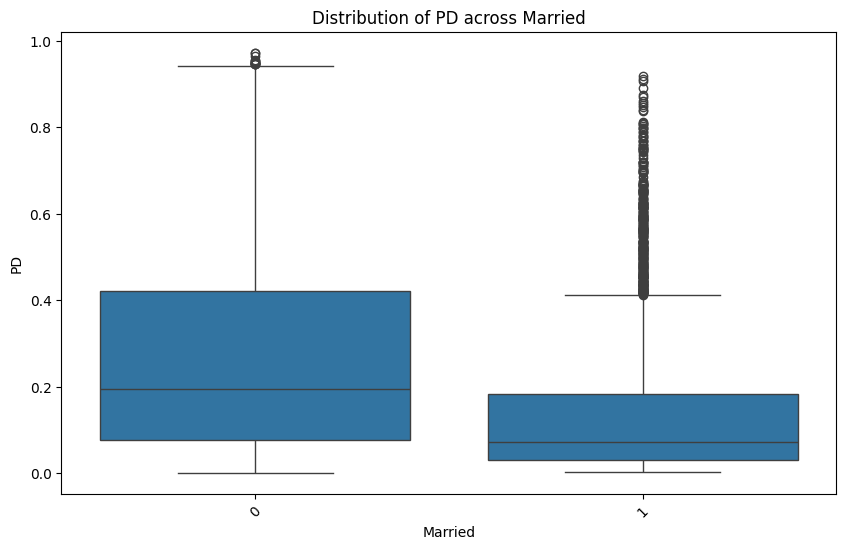

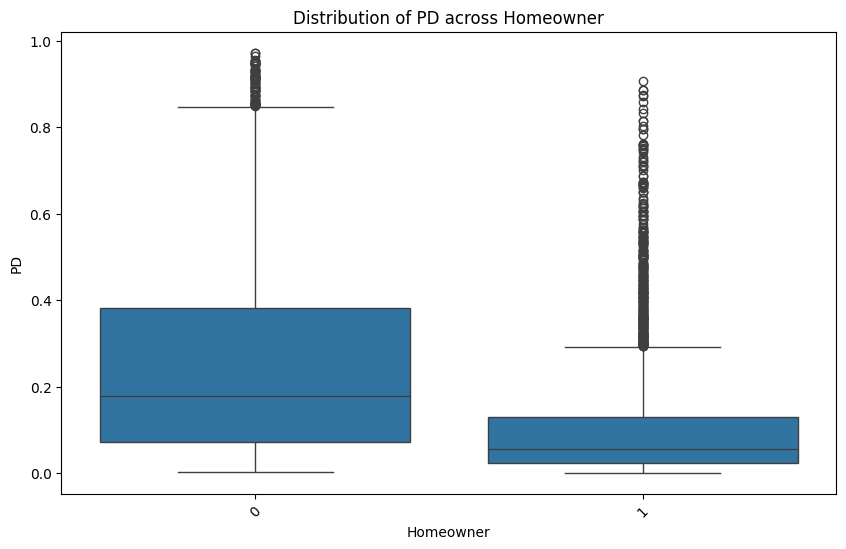

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through each categorical feature and plot a boxplot for the target 'PD'
for feature in cat_features:
    plt.figure(figsize=(10, 6))  # Adjust figure size if needed
    sns.boxplot(x=feature, y="PD", data=df)
    plt.title(f"Distribution of PD across {feature}")
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.show()

For many of the categorical features there are large jumps in median value and differences in spreads and interquartile range. This indicates there could be non linear relationships.

## 7. Check for Outliers

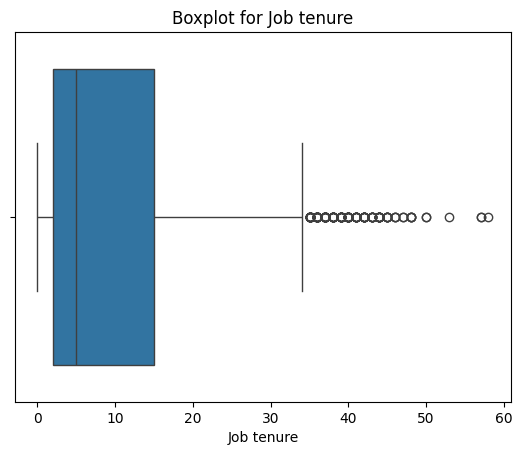

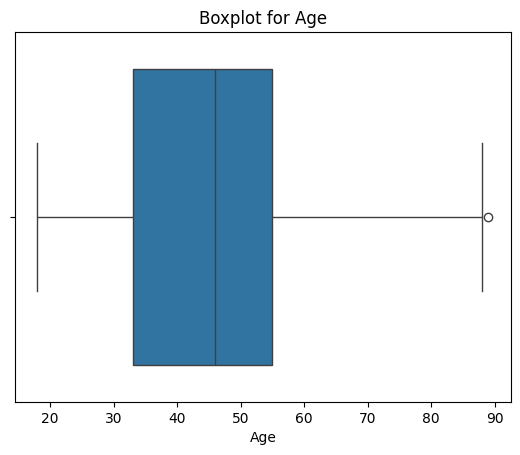

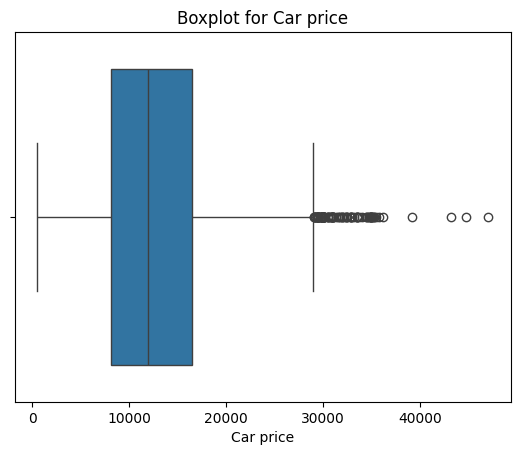

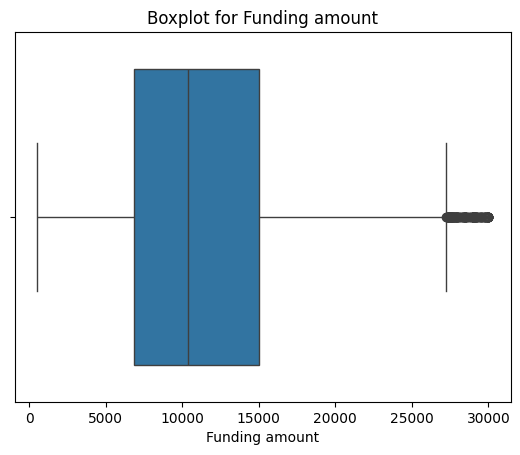

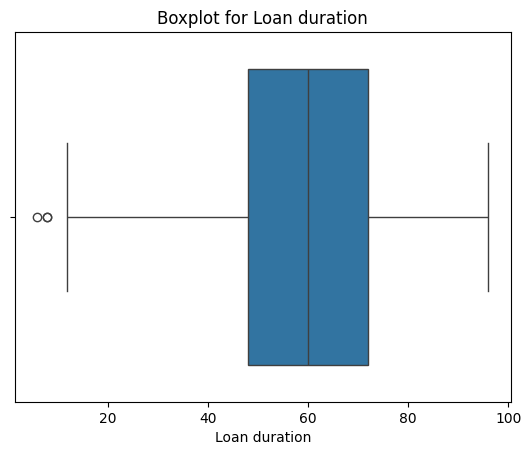

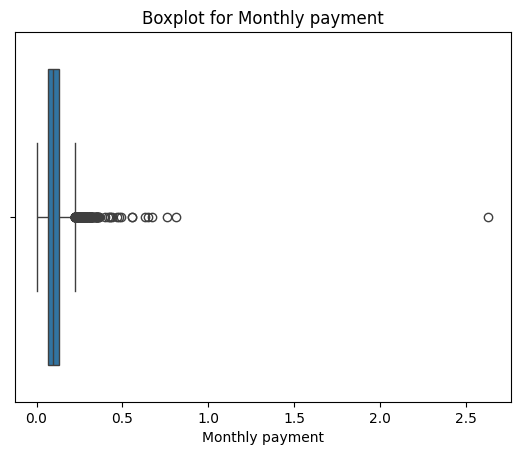

In [13]:
# Boxplot to detect outliers in continuous features
for col in num_features:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

There are some outliers. We should choose a model robust to this.

## 8. Check for Interactions

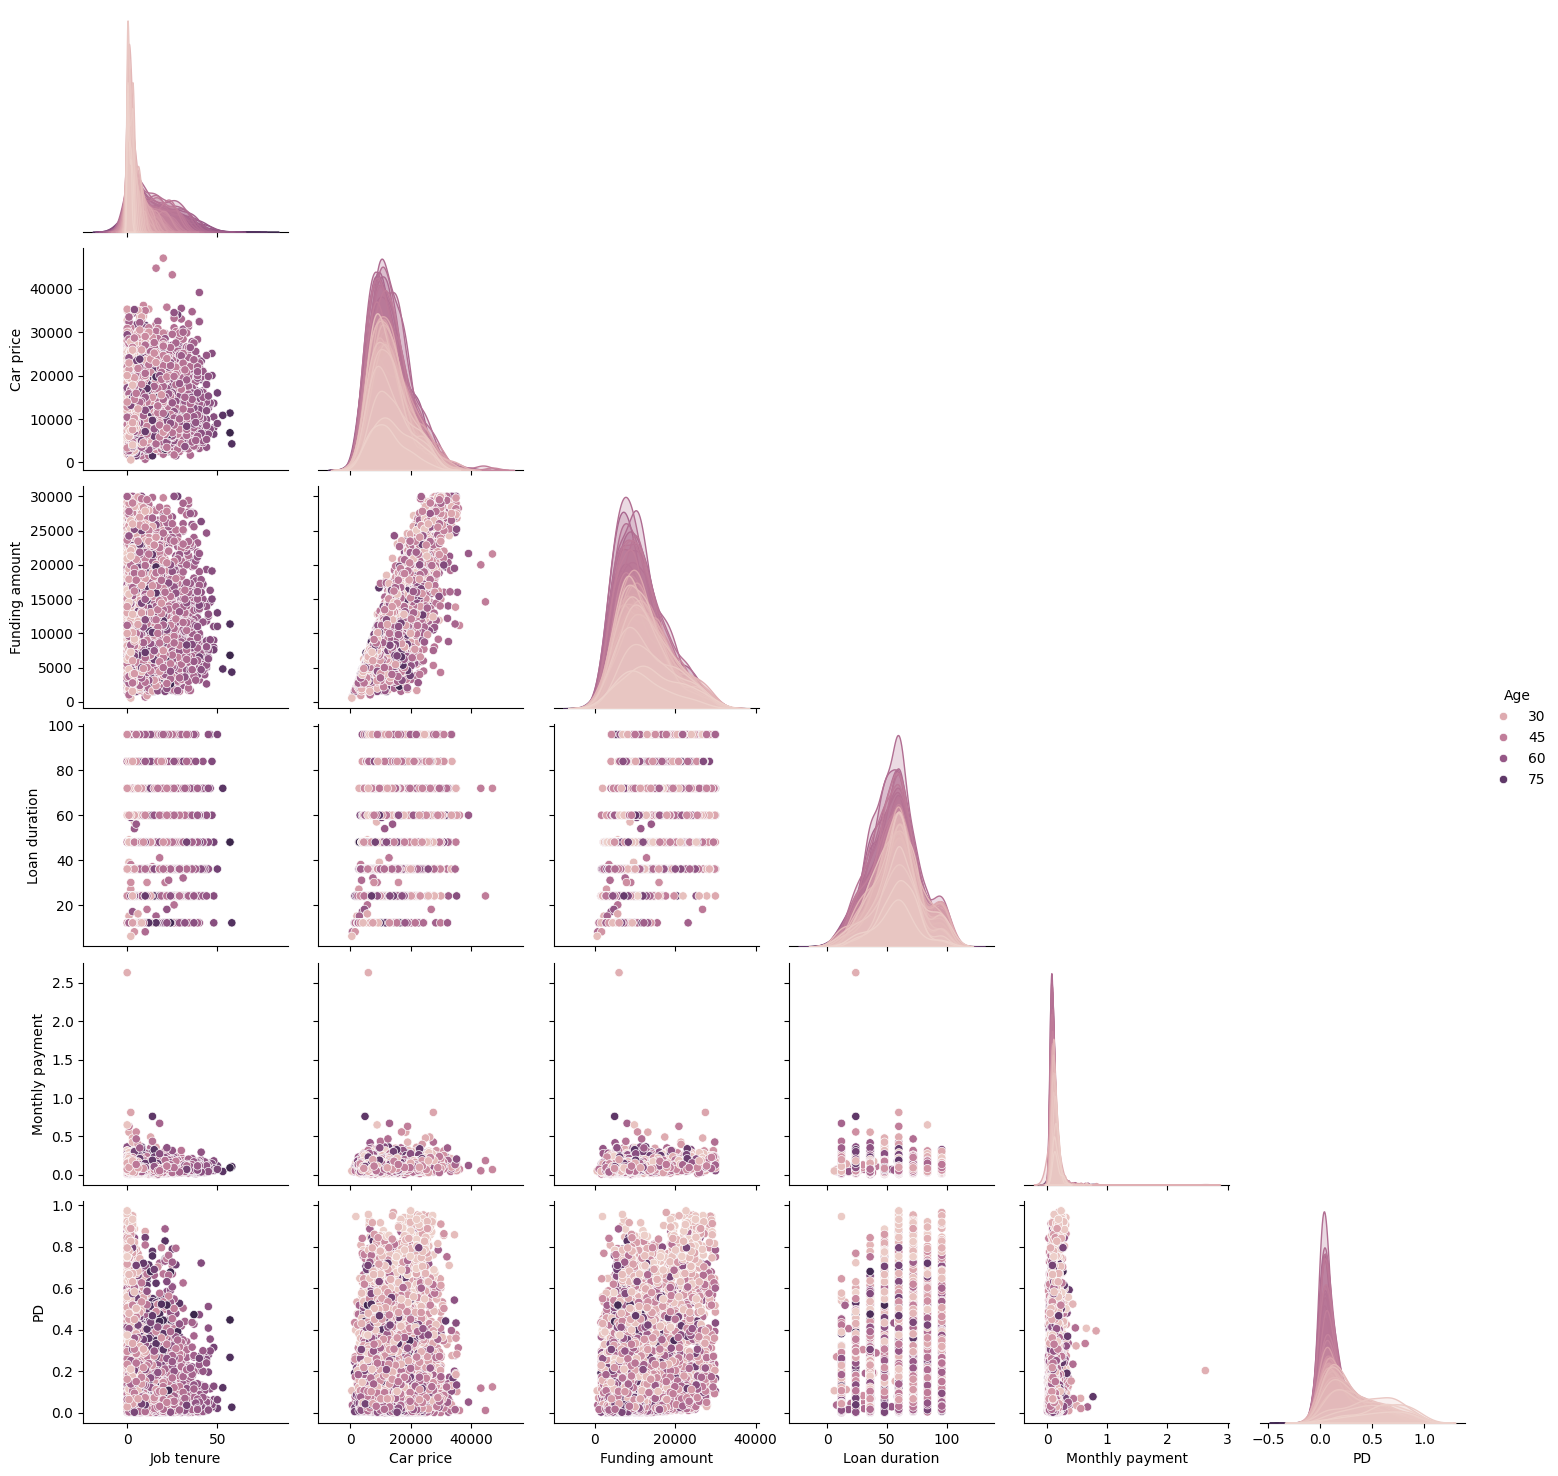

In [31]:
# Pairplot to detect potential interactions
sns.pairplot(df_num, hue="Age", corner=True)
plt.show()

There does seem to be interaction with age for several features like job tenure, car price, funding amount.

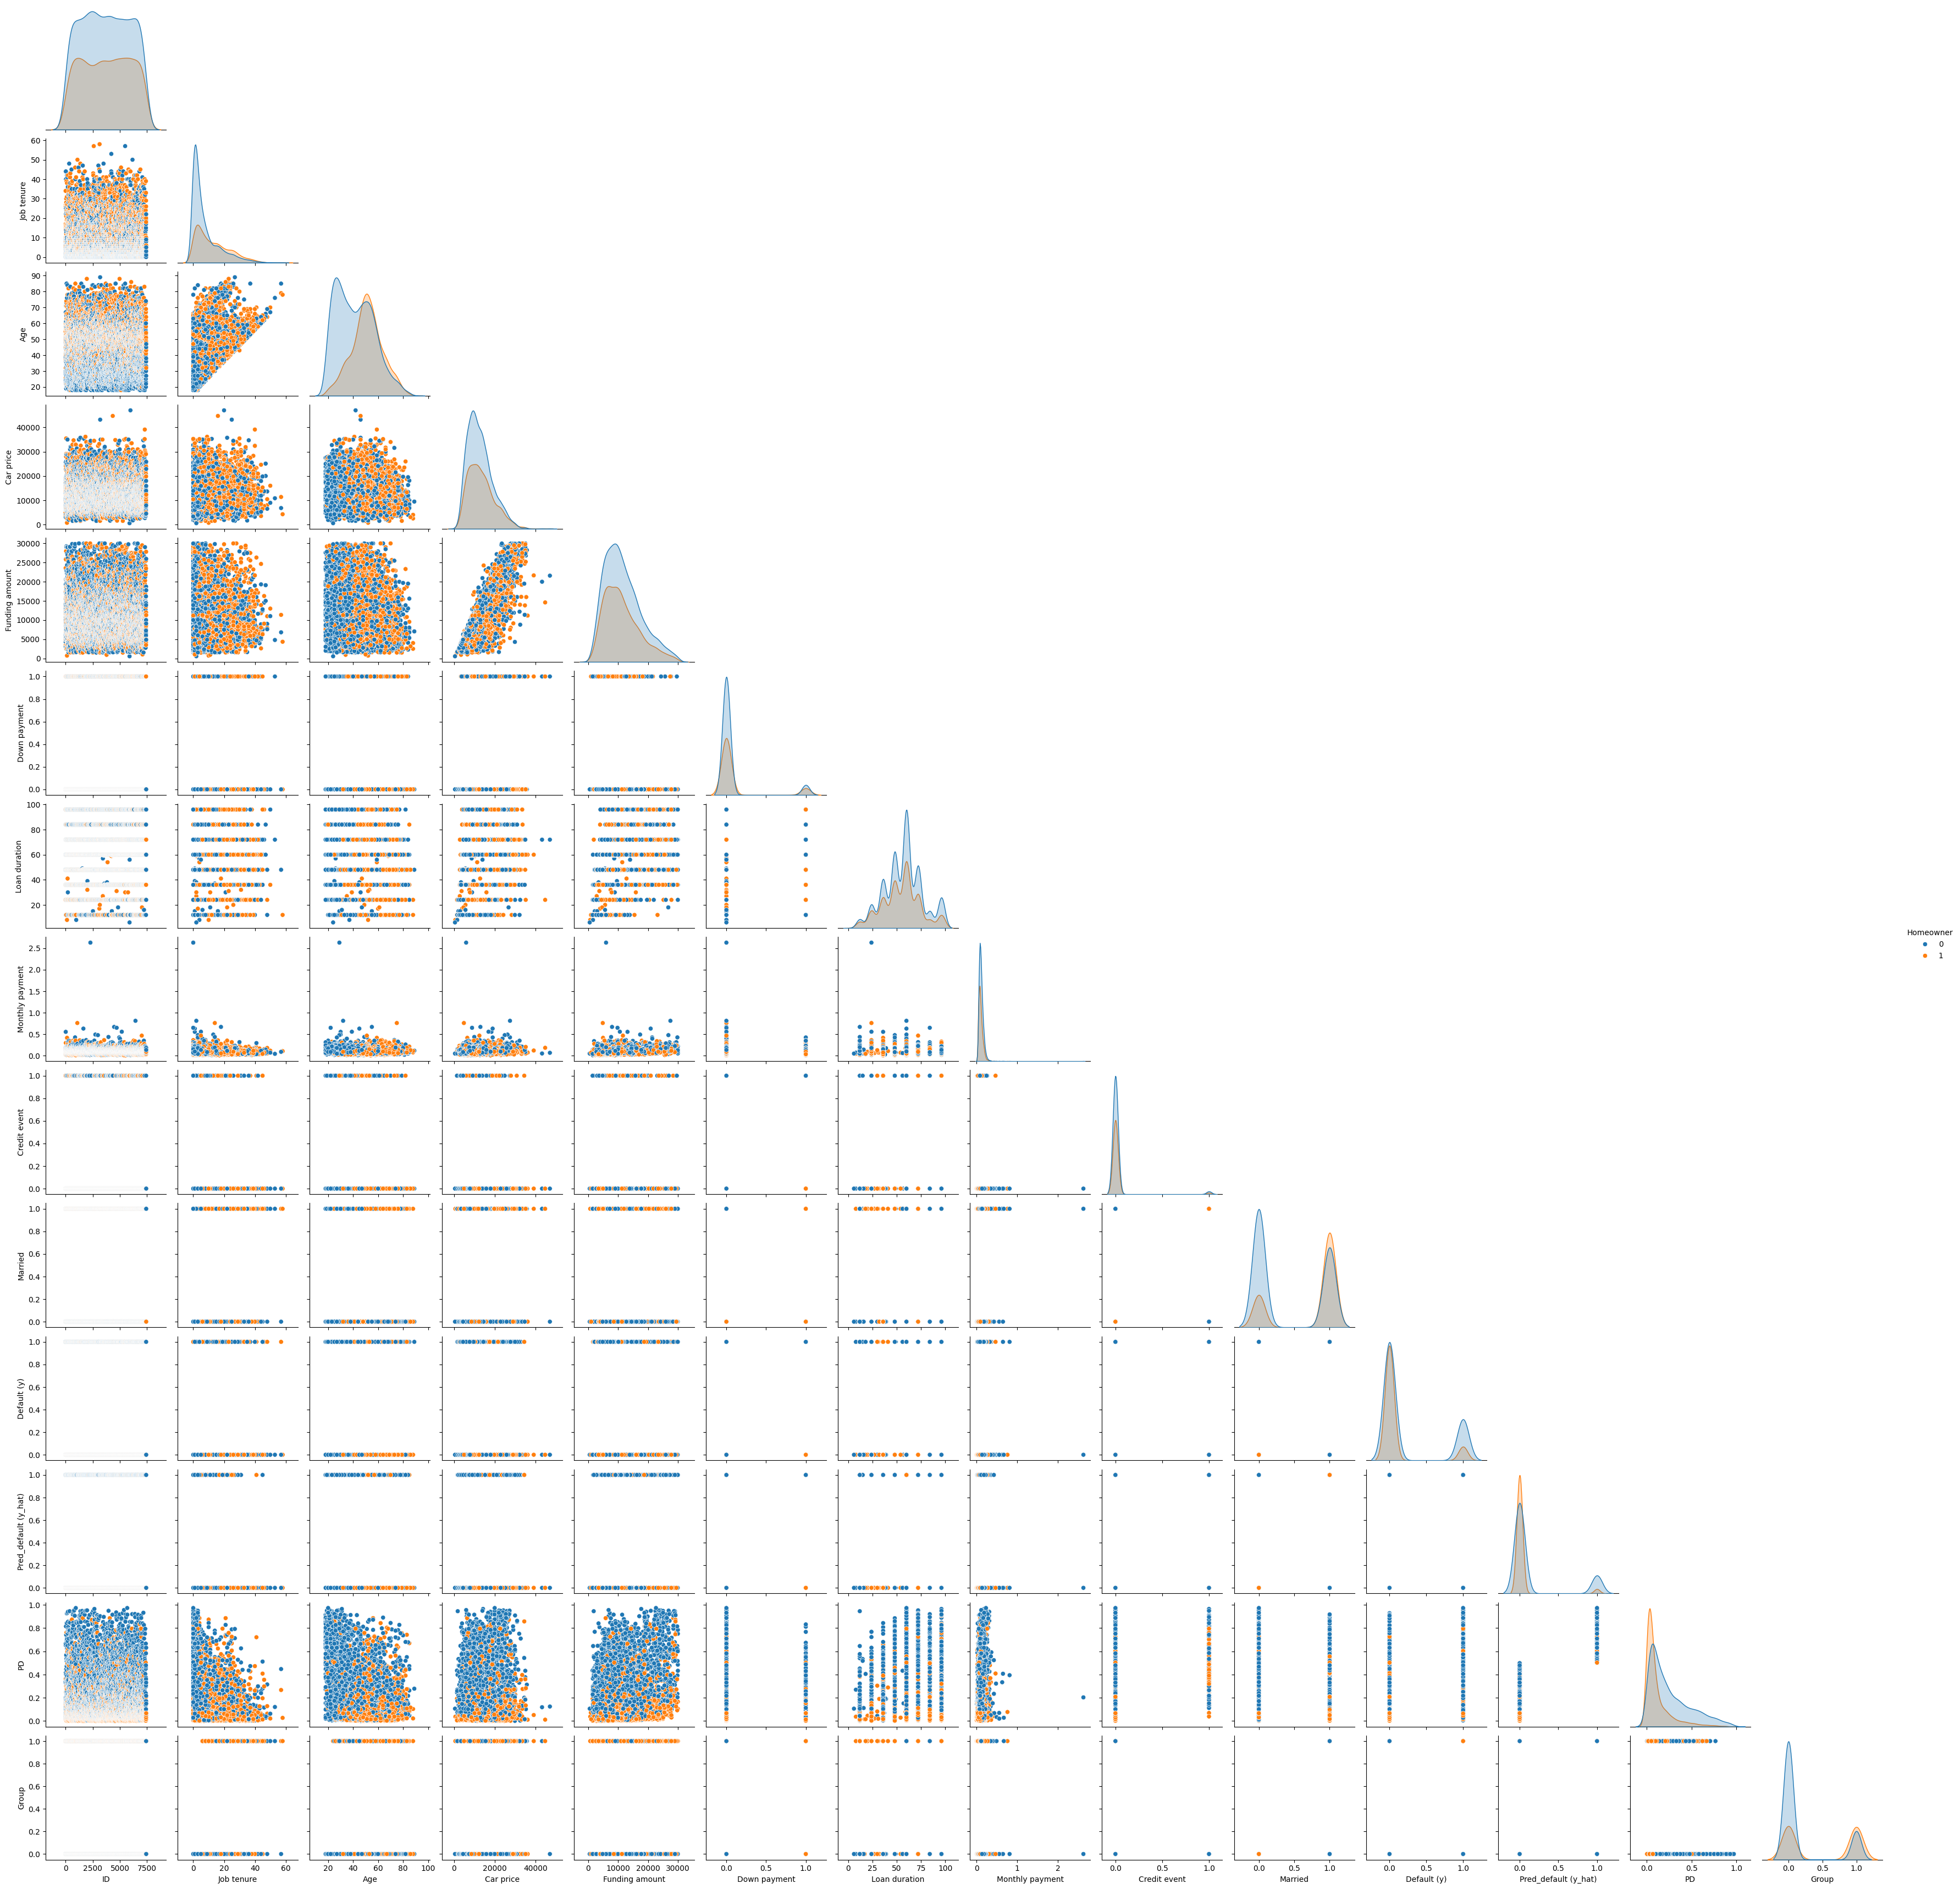

In [20]:
# Pairplot to detect potential interactions
sns.pairplot(df, hue="Homeowner", corner=True)
plt.show()

## 9. Check for class imbalance

In [22]:
# Check for class imbalance
sns.countplot(x="PD", data=df[cat_features])
plt.title("Class Distribution")
plt.show()

# Get the ratio of classes
class_counts = df["Default (y)"].value_counts()
print(f"Class balance:\n{class_counts}")

ValueError: Could not interpret value `PD` for `x`. An entry with this name does not appear in `data`.